# Data Exploration and Visualization of NOM Data in NMDC (FT ICR-MS)
This notebook identifies natural organic matter (NOM) data sets in the National Microbiome Data Collaborative (NMDC), filters those datasets based on quality control metrics, and analyzes the molecular composition of the chosen datasets via heatmaps and Van Krevelen plots.
This notebook uses the `nmdc_api_utilities` package (as of March 2025) to do this exploration. It involves using `nmdc_api_utilites` objects to make NMDC API requests easier, and using utility function to help us with data processing tasks. More information about the package can be found [here](https://microbiomedata.github.io/nmdc_api_utilities/)

In [1]:
%%capture
## First need to install locally the nmdc_api_utilities
%pip install nmdc_api_utilities;

In [2]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from matplotlib.patches import Patch
import nmdc_api_utilities

## Define a function to split a list into chunks 

Since we will need to use a list of ids to query a new collection in the API, we need to limit the number of ids we put in a query. This function splits a list into chunks of 100. Note that the `chunk_size` has a default of 100, but can be adjusted.

In [3]:
# Define a function to split ids into chunks
def split_list(input_list, chunk_size=100):
    result = []
    
    for i in range(0, len(input_list), chunk_size):
        result.append(input_list[i:i + chunk_size])
        
    return result

## Define a function to get a list of ids from initial results
In order to use the identifiers retrieved from an initial API request in another API request, this function is defined to take the initial request results and use the `id_name` key from the results to create a list of all the ids. The input is the initial result list and the name of the id field.

In [4]:
def get_id_list(result_list: list, id_name: str):
    id_list = []
    for item in result_list:
        if type(item[id_name]) == str:
            id_list.append(item[id_name])
        elif type(item[id_name]) == list:
            for another_item in item[id_name]:
                id_list.append(another_item)

    return id_list

### Gather the IDs for processed NOM results in NMDC by filtering for data objects of type "Direct Infusion FT ICR-MS"

Use the nmdc_api_utilies `DataObjectSearch` to gather processed NOM results. The function `get_record_by_attribute` gets record by input attribute name and value. See the documentation for more details [here](https://microbiomedata.github.io/nmdc_api_utilities/).

We pass in `data_object_type` using a keyword search of “Direct Infusion FT ICR-MS Analysis Results”. Extract the fields `id` (necessary for traversing the NMDC schema), `url` (necessary for pulling data) and `md5_checksum` (used to check uniqueness of data set). The fucntion will create the filter and API request from these paramters.

In [5]:
from nmdc_api_utilities.data_object_search import DataObjectSearch
dos_client = DataObjectSearch()
from nmdc_api_utilities.data_processing import DataProcessing
dp_client = DataProcessing()
processed_nom = dos_client.get_record_by_attribute(attribute_name='data_object_type', attribute_value='Direct Infusion FT-ICR MS Analysis Results', max_page_size=100, fields='id,md5_checksum,url', all_pages=True)
# clarify names
for dataobject in processed_nom:
    dataobject["processed_nom_id"] = dataobject.pop("id")
    dataobject["processed_nom_md5_checksum"] = dataobject.pop("md5_checksum")
    dataobject["processed_nom_url"] = dataobject.pop("url")

# convert to df
processed_nom_df = dp_client.convert_to_df(processed_nom)
processed_nom_df


processed_nom_id        processed_nom_md5_checksum  \
0     nmdc:dobj-11-003x7710  0391d9ff37a1926d5cf0eaec126ad4ff   
1     nmdc:dobj-11-00dewm52  2a532dca15798e470103ebd752a0937f   
2     nmdc:dobj-11-00wm3313  3ce562ac512457ea54bdda05a4f01ede   
3     nmdc:dobj-11-01kye625  38930c28eae561bc807bd01823f04167   
4     nmdc:dobj-11-02trja88  e6bafa5fabbebfb0061aa2587e223979   
...                     ...                               ...   
2578  nmdc:dobj-13-zrp1qw41  98b97b78fff542b66e72f4b3f792d80f   
2579  nmdc:dobj-13-zsqpnm92  3e9e19910edb209d211d9f915e36b8cb   
2580  nmdc:dobj-13-zvnmsp76  aec0521d6a36a440e41052f8eadc0d1d   
2581  nmdc:dobj-13-zvzx2462  9f0d52cc46d247b8d2ba12d5842b9fb6   
2582  nmdc:dobj-13-zye5fe51  8ddaeeffe93db9c4258a03e881d329cf   

                                      processed_nom_url  
0     https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...  
1     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
2     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
3     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
4     https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...  
...                                                 ...  
2578  https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...  
2579  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  
2580  https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...  
2581  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  
2582  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  

[2583 rows x 3 columns]

### Continue traversing the NMDC schema by using the list of identifiers from the previous API call to query the next collection

Find the analysis records that produced these processed nom object IDs by matching object `processed_nom_id` to the `has_output` slot with a filter and the WorkflowExecutionSearch object. Also extract the `has_input` slot as it will be used for the next traversal, grabbing the raw data objects that are used as input to the nom analysis records.

In [6]:
from nmdc_api_utilities.workflow_execution_search import WorkflowExecutionSearch
# since we are querying the WorkflowExecution collection, we need to create an instance of it
we_client = WorkflowExecutionSearch()
# use utility function to get a list of the ids from processed_nom
result_ids = get_id_list(processed_nom, "processed_nom_id")
# create a list of lists of ids to query the WorkflowExecutionSearch object
chunked_list = split_list(result_ids)
analysis_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the WorkflowExecutionSearch object looking for data objects where the has_output field is in the chunk of ids from processed_nom
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
    # get the results
    analysis_dataobj += we_client.get_record_by_filter(filter=filter, fields="id,has_input,has_output", max_page_size=100, all_pages=True)

# clarify names
for dataobject in analysis_dataobj:
    dataobject["analysis_id"] = dataobject.pop("id")
    dataobject["analysis_has_input"] = dataobject.pop("has_input")
    dataobject["analysis_has_output"] = dataobject.pop("has_output")

# convert to data frame
analysis_dataobj_df = dp_client.convert_to_df(analysis_dataobj)
analysis_dataobj_df

analysis_id  \
0     nmdc:wfnom-11-dv3wck24.1   
1     nmdc:wfnom-11-0mqv1c63.1   
2     nmdc:wfnom-11-twkd5a03.1   
3     nmdc:wfnom-11-ftaq2319.1   
4     nmdc:wfnom-11-2dcp9q04.1   
...                        ...   
2578  nmdc:wfnom-13-08q56295.1   
2579  nmdc:wfnom-13-yy5yqx31.1   
2580  nmdc:wfnom-13-4xrsd836.1   
2581  nmdc:wfnom-13-h0r53g59.1   
2582  nmdc:wfnom-13-4vmrb525.1   

                                  analysis_has_input      analysis_has_output  
0     [nmdc:dobj-11-2ysghy98, nmdc:dobj-11-bmeg5b74]  [nmdc:dobj-11-003x7710]  
1                            [nmdc:dobj-11-3hfzr472]  [nmdc:dobj-11-00dewm52]  
2                            [nmdc:dobj-11-2mk4qf09]  [nmdc:dobj-11-00wm3313]  
3                            [nmdc:dobj-11-7wynt887]  [nmdc:dobj-11-01kye625]  
4                            [nmdc:dobj-11-ge6pre79]  [nmdc:dobj-11-02trja88]  
...                                              ...                      ...  
2578                         [nmdc:dobj-13-vg0tgv60]  [nmdc:dobj-13-zrp1qw41]  
2579                         [nmdc:dobj-13-w15zk074]  [nmdc:dobj-13-zsqpnm92]  
2580                         [nmdc:dobj-13-3rmgcm64]  [nmdc:dobj-13-zvnmsp76]  
2581                         [nmdc:dobj-13-m3zkxg02]  [nmdc:dobj-13-zvzx2462]  
2582                         [nmdc:dobj-13-60z8rt70]  [nmdc:dobj-13-zye5fe51]  

[2583 rows x 3 columns]

Find the raw data objects used as input for these analysis records by matching the analysis record's `has_input` slot to the `id` slot in the collection `data_object_set`. Create a DataObjectSearch object to do so.

Workflows can take multiple inputs (eg. configuration or parameter files) in addition to the raw data, so we will filter the results to only keep raw data object IDs.

In [7]:
# use utility function to get a list of the ids from raw_dataobj
result_ids = get_id_list(analysis_dataobj, "analysis_has_input")
# create a list of lists of ids to query the DataObjectSearch object
chunked_list = split_list(result_ids)
raw_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the DataObjectSearch object looking for data objects where the id field is in the chunk of ids from analysis_dataobj
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    raw_dataobj += dos_client.get_record_by_filter(filter=filter, fields="id,name,data_object_type", max_page_size=100, all_pages=True)

# clarify names
for dataobject in raw_dataobj:
    dataobject["raw_id"] = dataobject.pop("id")
    dataobject["raw_name"] = dataobject.pop("name")

# Filter out parameter files (leave NAs in case raw data files are missing a label)
param_dataobj = [file for file in raw_dataobj if 'data_object_type' in file and file['data_object_type'] == 'Analysis Tool Parameter File']
raw_dataobj = [file for file in raw_dataobj if file not in param_dataobj]

raw_df = dp_client.convert_to_df(raw_dataobj)

raw_df


data_object_type                 raw_id  \
0     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-04embv91   
1     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-04ny1n21   
2     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-09p17z03   
3     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-0cmhqk17   
4     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-10madc26   
...                                  ...                    ...   
2578  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-vcsgr863   
2579  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-vg0tgv60   
2580  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-vya84d93   
2581  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-w15zk074   
2582  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-zazrqk87   

                                               raw_name  
0     Lybrand_FT_62_W_23Aug19_Alder_Infuse_p3_1_01_4...  
1     Lybrand_FT_36_C_30Aug19_Alder_Infuse_p05_1_01_...  
2     Lybrand_Permafrost_BOG_14_CHCl3_13Dec19_Alder_...  
3     WHONDRS_S19S_0059_ICR_1_43_Alder_Inf_13Sept19_...  
4     WHONDRS_S19S_015_17Mar20_Alder_Infuse_P2_1_01_...  
...                                                 ...  
2578        output: Brodie_181_MeOH_R2_21Mar19_HESI_Neg  
2579  output: SBR_FC_S3_30-40_H2Oext_13Oct15_Leopard...  
2580           output: Brodie_152_w_r2_29Jan19_HESI_neg  
2581  output: Brodie_135A_H2O_15Oct18_IAT_p1_1_01_35894  
2582           output: Brodie_185_w_r1_01Feb19_HESI_neg  

[2583 rows x 3 columns]

Find the data generation records that produced these raw data objects by matching the data object's `id` slot to the `has_output` slot in the collection `data_generation_set`. Create a DataGenerationSearch object to do so. Once again extract the `has_input` slot as it will be used for the next traversal, grabbing the biosample data objects that are used as input to the data generation records.

In [8]:
from nmdc_api_utilities.data_generation_search import DataGenerationSearch
dgs_client = DataGenerationSearch()
# use utility function to get a list of the ids from raw_dataobj
result_ids = get_id_list(raw_dataobj, "raw_id")
# create a list of lists of ids to query the DataGenerationSearch object
chunked_list = split_list(result_ids)
datageneration_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the DataGenerationSearch object looking for data objects that have the raw_id in the has_output field
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
    # get the results
    datageneration_dataobj += dgs_client.get_record_by_filter(filter=filter, fields="id,has_input,has_output", max_page_size=100, all_pages=True)

# clarify names
for dataobject in datageneration_dataobj:
    dataobject["datageneration_id"] = dataobject.pop("id")
    dataobject["datageneration_has_output"] = dataobject.pop("has_output")
    dataobject["datageneration_has_input"] = dataobject.pop("has_input")
# convert to data frame
datageneration_dataobj_df = dp_client.convert_to_df(datageneration_dataobj)
datageneration_dataobj_df

datageneration_id datageneration_has_output  \
0     nmdc:omprc-11-vfj8z279   [nmdc:dobj-11-01q67939]   
1     nmdc:omprc-11-adjx8k29   [nmdc:dobj-11-04embv91]   
2     nmdc:omprc-11-w1kvtj73   [nmdc:dobj-11-04ny1n21]   
3     nmdc:omprc-11-rj3bqn04   [nmdc:dobj-11-09p17z03]   
4     nmdc:omprc-11-a1szxs11   [nmdc:dobj-11-0cmhqk17]   
...                      ...                       ...   
2578  nmdc:omprc-11-077nww93   [nmdc:dobj-13-zjrg8w43]   
2579  nmdc:omprc-11-s9xtq276   [nmdc:dobj-13-zpzv3z08]   
2580  nmdc:omprc-13-8hsd4d19   [nmdc:dobj-13-zymvcs73]   
2581  nmdc:omprc-13-ef1v6r85   [nmdc:dobj-13-zz1a8884]   
2582  nmdc:omprc-13-xemx6b61   [nmdc:dobj-13-zzzyae97]   

       datageneration_has_input  
0        [nmdc:bsm-11-7t0qgt55]  
1        [nmdc:bsm-11-ax989290]  
2        [nmdc:bsm-11-tea8p723]  
3        [nmdc:bsm-11-6aqn1d84]  
4        [nmdc:bsm-11-b7c2dc48]  
...                         ...  
2578  [nmdc:procsm-11-s1ypy935]  
2579  [nmdc:procsm-11-2nexmt97]  
2580  [nmdc:procsm-11-4bpnn544]  
2581  [nmdc:procsm-11-8hrn7z73]  
2582  [nmdc:procsm-11-t7qjg604]  

[2583 rows x 3 columns]

Find the biosample data objects used as input for these data generation records by matching the processing record's `has_input` slot to the `id` slot in the collection `biosample_set`. Create a BiosampleSearch object to do so. Query all fields in this API call by excluding the fields parameter and utilize informative columns to group biosamples into a `type`. 

In [9]:
from nmdc_api_utilities.biosample_search import BiosampleSearch
bs_client = BiosampleSearch()

# use utility function to get a list of the ids from datageneration_dataobj
result_ids = get_id_list(datageneration_dataobj, "datageneration_has_input")
# create a list of lists of ids to query the BiosampleSearch object
chunked_list = split_list(result_ids)
biosample_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the BiosampleSearch object looking for data objects where the id is in the chunk of ids from datageneration_dataobj
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    biosample_dataobj += bs_client.get_record_by_filter(filter=filter, max_page_size=100, all_pages=True)

# clarify names
for dataobject in biosample_dataobj:
    dataobject["biosample_id"] = dataobject.pop("id")

# convert to data frame
biosample_dataobj_df = dp_client.convert_to_df(biosample_dataobj)

biosample_dataobj_df

env_broad_scale  \
0     {'has_raw_value': 'urban biome [ENVO:01000249]...   
1     {'has_raw_value': 'ENVO:00000446', 'term': {'i...   
2     {'has_raw_value': 'anthropogenic terrestrial b...   
3     {'has_raw_value': 'ENVO:00000446', 'term': {'i...   
4     {'has_raw_value': 'anthropogenic terrestrial b...   
...                                                 ...   
1493  {'has_raw_value': 'ENVO:01000221', 'term': {'i...   
1494  {'has_raw_value': 'ENVO:01000221', 'term': {'i...   
1495  {'has_raw_value': 'ENVO:01000221', 'term': {'i...   
1496  {'has_raw_value': 'ENVO:01000221', 'term': {'i...   
1497  {'has_raw_value': 'ENVO:01000221', 'term': {'i...   

                                        env_local_scale  \
0     {'has_raw_value': 'woodland clearing [ENVO:000...   
1     {'has_raw_value': 'ENVO:01000861', 'term': {'i...   
2     {'has_raw_value': 'agricultural field [ENVO:00...   
3     {'has_raw_value': 'ENVO:01000861', 'term': {'i...   
4     {'has_raw_value': 'agricultural field [ENVO:00...   
...                                                 ...   
1493  {'has_raw_value': 'ENVO:00005784', 'term': {'i...   
1494  {'has_raw_value': 'ENVO:00005784', 'term': {'i...   
1495  {'has_raw_value': 'ENVO:00005784', 'term': {'i...   
1496  {'has_raw_value': 'ENVO:00005784', 'term': {'i...   
1497  {'has_raw_value': 'ENVO:00005784', 'term': {'i...   

                                             env_medium  \
0     {'has_raw_value': 'forest soil [ENVO:00002261]...   
1     {'has_raw_value': 'ENVO:00001998', 'term': {'i...   
2     {'has_raw_value': 'agricultural soil [ENVO:000...   
3     {'has_raw_value': 'ENVO:00001998', 'term': {'i...   
4     {'has_raw_value': 'agricultural soil [ENVO:000...   
...                                                 ...   
1493  {'has_raw_value': 'ENVO:00005774', 'term': {'i...   
1494  {'has_raw_value': 'ENVO:00005774', 'term': {'i...   
1495  {'has_raw_value': 'ENVO:00005774', 'term': {'i...   
1496  {'has_raw_value': 'ENVO:00005774', 'term': {'i...   
1497  {'has_raw_value': 'ENVO:00005774', 'term': {'i...   

                     samp_name  \
0               WLUP_CoreB_TOP   
1               Lybrand_GHG_18   
2               PRS2_CoreB_TOP   
3     Lybrand_Permafrost_HE_02   
4               PRS1_CoreB_BTM   
...                        ...   
1493                       NaN   
1494                       NaN   
1495                       NaN   
1496                       NaN   
1497                       NaN   

                             emsl_biosample_identifiers  \
0     [UUID:WLUP-CB-T-a07898a8-bff9-4bc2-ae4c-345682...   
1                                                   NaN   
2     [UUID:PSR2-CB-T-177b015d-e006-4aca-977d-c9c118...   
3                                                   NaN   
4     [UUID:PSR1-CB-B-60b61105-073e-4d04-b3dc-452479...   
...                                                 ...   
1493        [emsl:2f7118c0-5dd1-11ec-bf63-0242ac130002]   
1494        [emsl:2f7116fe-5dd1-11ec-bf63-0242ac130002]   
1495        [emsl:2f711028-5dd1-11ec-bf63-0242ac130002]   
1496        [emsl:2f7109ac-5dd1-11ec-bf63-0242ac130002]   
1497        [emsl:2f7105c4-5dd1-11ec-bf63-0242ac130002]   

                                       carb_nitro_ratio  \
0     {'has_raw_value': '15.699', 'type': 'nmdc:Quan...   
1                                                   NaN   
2     {'has_raw_value': '9.6', 'type': 'nmdc:Quantit...   
3                                                   NaN   
4     {'has_raw_value': '10.092', 'type': 'nmdc:Quan...   
...                                                 ...   
1493                                                NaN   
1494                                                NaN   
1495                                                NaN   
1496                                                NaN   
1497                                                NaN   

                                        collection_date  \
0     {'has_raw_value': '20

Assign a general type for each sample by parsing their ENVO IDs. This was done manually by searching ENVO ID's on the [ontology search website](https://www.ebi.ac.uk/ols4/ontologies/envo).

In [10]:
biosample_dataobj_flat=pd.json_normalize(biosample_dataobj)
biosample_dataobj_flat_df=dp_client.convert_to_df(biosample_dataobj_flat)

biosample_dataobj_flat_df['sample_type']=""

biosample_dataobj_flat_df['env_medium.term.id'].drop_duplicates()

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.name'].str.contains('soil', na = False),'sample_type'] = 'soil'

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002261","ENVO:00001998","ENVO:00002259",
                                                                                    "ENVO:01001616","ENVO:00005750","ENVO:00005761",
                                                                                    "ENVO:00005760","ENVO:00005773","ENVO:00005802",
                                                                                    "ENVO:00005774"]),'sample_type'] = 'soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002042"]),'sample_type'] = 'water'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002007"]),'sample_type'] = 'sediment'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:01000017"]),'sample_type'] = 'sand'

#filter to desired metadata columns
biosample_dataobj_flat_df=biosample_dataobj_flat_df[['biosample_id','geo_loc_name.has_raw_value','env_medium.term.name','env_medium.term.id','sample_type']]

biosample_dataobj_flat_df

biosample_id                         geo_loc_name.has_raw_value  \
0     nmdc:bsm-11-12esnc57         USA: Maryland, Winters Lane Upper Soil Pit   
1     nmdc:bsm-11-23w82g32                                 USA: Alaska, Healy   
2     nmdc:bsm-11-2d3eam48        USA: Washington, Prosser Non-irrigated Bare   
3     nmdc:bsm-11-2n9dds87                                 USA: Alaska, Healy   
4     nmdc:bsm-11-2prjdm84            USA: Washington, Prosser Irrigated Bare   
...                    ...                                                ...   
1493  nmdc:bsm-13-tk2ebg43  USA: Minnesota, Marcel Experimental Forest, Sp...   
1494  nmdc:bsm-13-zaezdc83  USA: Minnesota, Marcel Experimental Forest, Sp...   
1495  nmdc:bsm-13-d8z0bz72  USA: Minnesota, Marcel Experimental Forest, Sp...   
1496  nmdc:bsm-13-gfj46v76  USA: Minnesota, Marcel Experimental Forest, Sp...   
1497  nmdc:bsm-13-pwrd7087  USA: Minnesota, Marcel Experimental Forest, Sp...   

     env_medium.term.name env_medium.term.id sample_type  
0            forest soil       ENVO:00002261        soil  
1                    soil      ENVO:00001998        soil  
2      agricultural soil       ENVO:00002259        soil  
3                    soil      ENVO:00001998        soil  
4      agricultural soil       ENVO:00002259        soil  
...                   ...                ...         ...  
1493                  NaN      ENVO:00005774        soil  
1494                  NaN      ENVO:00005774        soil  
1495                  NaN      ENVO:00005774        soil  
1496                  NaN      ENVO:00005774        soil  
1497                  NaN      ENVO:00005774        soil  

[1498 rows x 5 columns]

### Create final data frame of relevant metadata and NMDC schema information for each NOM processed data object

Create merged dataframe with results from schema traversal and metadata using the DataProcessing object created earlier. 

In [11]:
#match all processed nom objects (via processed_nom_id) to analysis objects (via analysis_has_output) and expand lists has_input and has_output
processed_obj_to_analysis_df=dp_client.merge_df(processed_nom_df,analysis_dataobj_df,"processed_nom_id","analysis_has_output")

#match raw data objects (via raw_id) to all_analysis_df (via analysis_has_input)
processed_obj_to_raw_df=dp_client.merge_df(raw_df,processed_obj_to_analysis_df,"raw_id","analysis_has_input")

#match processed_obj_to_raw_df (via raw_id) to data generation objects (via datageneration_has_output) and expand lists has_input and has_output
processed_obj_to_datagen_df=dp_client.merge_df(processed_obj_to_raw_df,datageneration_dataobj_df,"raw_id","datageneration_has_output")

#match biosample objects (via biosample_id) to processed_obj_to_datagen_df (via datageneration_has_input)
merged_df=dp_client.merge_df(biosample_dataobj_flat_df,processed_obj_to_datagen_df,"biosample_id","datageneration_has_input")

merged_df

biosample_id                         geo_loc_name.has_raw_value  \
0     nmdc:bsm-11-12esnc57         USA: Maryland, Winters Lane Upper Soil Pit   
1     nmdc:bsm-11-12esnc57         USA: Maryland, Winters Lane Upper Soil Pit   
2     nmdc:bsm-11-12esnc57         USA: Maryland, Winters Lane Upper Soil Pit   
3     nmdc:bsm-11-12esnc57         USA: Maryland, Winters Lane Upper Soil Pit   
4     nmdc:bsm-11-12esnc57         USA: Maryland, Winters Lane Upper Soil Pit   
...                    ...                                                ...   
5433  nmdc:bsm-13-4bfysc34  USA: Minnesota, Marcel Experimental Forest, Sp...   
5434  nmdc:bsm-13-4bfysc34  USA: Minnesota, Marcel Experimental Forest, Sp...   
5435  nmdc:bsm-13-4bfysc34  USA: Minnesota, Marcel Experimental Forest, Sp...   
5454  nmdc:bsm-13-tk2ebg43  USA: Minnesota, Marcel Experimental Forest, Sp...   
5455  nmdc:bsm-13-tk2ebg43  USA: Minnesota, Marcel Experimental Forest, Sp...   

     env_medium.term.name env_medium.term.id sample_type  \
0            forest soil       ENVO:00002261        soil   
1            forest soil       ENVO:00002261        soil   
2            forest soil       ENVO:00002261        soil   
3            forest soil       ENVO:00002261        soil   
4            forest soil       ENVO:00002261        soil   
...                   ...                ...         ...   
5433                  NaN      ENVO:00005774        soil   
5434                  NaN      ENVO:00005774        soil   
5435                  NaN      ENVO:00005774        soil   
5454                  NaN      ENVO:00005774        soil   
5455                  NaN      ENVO:00005774        soil   

                        data_object_type                 raw_id  \
0     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-gdhnkg66   
1     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-vkheqz50   
2     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-qt6pmm77   
3     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-z002ga43   
4     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-hdd01t09   
...                                  ...                    ...   
5433  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-zjmw5b65   
5434  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-xx781m34   
5435  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-b28x6912   
5454  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-p6nbwp18   
5455  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-r4nvvk04   

                                               raw_name  \
0     1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300...   
1     1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300...   
2     1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300...   
3     1000S_WLUP_FTMS_SPE_TOP_2_run2_Fir_22Apr22_300...   
4     1000S_WLUP_FTMS_SPE_TOP_1_run1_Fir_22Apr22_300...   
...                                                 ...   
5433    Rachael_21T_04-15A_C_20Mar17_leopard_Infuse.raw   
5434    Rachael_21T_04-15A_M_14Mar17_leopard_Infuse.raw   
5435    Rachael_21T_04-15A_M_03Mar17_leopard_Infuse.raw   
5454     Rachael_21T_19-15_M_14Mar17_leopard_Infuse.raw   
5455     Rachael_21T_19-15_C_20Mar17_leopard_Infuse.raw   

           processed_nom_id        processed_nom_md5_checksum  \
0     nmdc:dobj-11-0dyc2f79  9ace043441672422f7991411014ab9cb   
1     nmdc:dobj-11-07gsmc68  9363e9de79c39013257ddb4d967006b2   
2     nmdc:dobj-11-jj2r0a49  a502ec422a6f960972b759b143d8ad9c   
3     nmdc:dobj-11-mmdwds36  dff9718e9428ec3aa77fed987deb637d   
4     nmdc:dobj-11-s42fww29  05cf8e9c0394dbdf80c3c6b89a4f3956   
...                     ...                               ...   
5433  nmdc:dobj-13-ndcybr82  96687259609750c22df604fb2d048abe   
5434  nmdc:dobj-13-nxv2mc44  6110cf11b16b2553b7dbe64d89c3f112   
5435  nmdc:dobj-13-xstcrm22  8d0fa20919a57eb5bd5eaf1f3bf60342   
5454  nmdc:dobj-13-n2g0fg49  8ace8bbe037be3d09031d60f12d56010   
5455  nmdc:dobj-13-t7bfec16  2b2e4204fa2cf843dd19af5746f1be13   

                         

Use the md5_checksum to check that each row/processed NOM object has an associated url that is unique

In [12]:
#are there any md5_checksum values that occur more than once (i.e. are associated with more than one processed nom id)
len(merged_df[merged_df.duplicated('processed_nom_md5_checksum')]['processed_nom_md5_checksum'].unique())==0

True

Clean up final dataframe, removing unneeded/intermediate identifier columns from schema traversal.

In [13]:
column_list = merged_df.columns.tolist()
columns_to_keep = ["biosample_id","processed_nom_id","sample_type","processed_nom_url"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))

# Drop unnecessary columns
merged_df_cleaned = merged_df.drop(columns=columns_to_remove)

# remove duplicate rows when keeping only necessary columns (should remove none)
final_df=merged_df_cleaned.drop_duplicates(keep="first")

final_df


biosample_id sample_type       processed_nom_id  \
0     nmdc:bsm-11-12esnc57        soil  nmdc:dobj-11-0dyc2f79   
1     nmdc:bsm-11-12esnc57        soil  nmdc:dobj-11-07gsmc68   
2     nmdc:bsm-11-12esnc57        soil  nmdc:dobj-11-jj2r0a49   
3     nmdc:bsm-11-12esnc57        soil  nmdc:dobj-11-mmdwds36   
4     nmdc:bsm-11-12esnc57        soil  nmdc:dobj-11-s42fww29   
...                    ...         ...                    ...   
5433  nmdc:bsm-13-4bfysc34        soil  nmdc:dobj-13-ndcybr82   
5434  nmdc:bsm-13-4bfysc34        soil  nmdc:dobj-13-nxv2mc44   
5435  nmdc:bsm-13-4bfysc34        soil  nmdc:dobj-13-xstcrm22   
5454  nmdc:bsm-13-tk2ebg43        soil  nmdc:dobj-13-n2g0fg49   
5455  nmdc:bsm-13-tk2ebg43        soil  nmdc:dobj-13-t7bfec16   

                                      processed_nom_url  
0     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
1     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
2     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
3     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
4     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
...                                                 ...  
5433  https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...  
5434  https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...  
5435  https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...  
5454  https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...  
5455  https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...  

[1614 rows x 4 columns]

### Calculate quality control statistics on processed nom results (this takes a while to run)

Explore what the files associated with these NOM data objects look like. 

In [14]:
#example file
url=final_df.iloc[0]["processed_nom_url"]

#pull data as csv using url
response = requests.get(url)
csv_data = StringIO(response.text)
csv_df = pd.read_csv(csv_data)
csv_data.close()
csv_df

Index          m/z  Calibrated m/z  Calculated m/z   Peak Height  \
0        10   121.029630      121.029532      121.029503  2.053749e+07   
1        14   125.024551      125.024447      125.024418  6.872170e+06   
2        19   127.040191      127.040084      127.040068  6.932442e+06   
3        21   127.076580      127.076473      127.076453  7.184993e+06   
4        25   129.055855      129.055746      129.055718  3.702771e+08   
...     ...          ...             ...             ...           ...   
8184   8176   854.742128      854.740814             NaN  8.781581e+06   
8185   8179   857.253655      857.252336             NaN  8.486738e+06   
8186   8180   914.166591      914.165162             NaN  6.141723e+06   
8187   8182   935.768503      935.767031             NaN  7.808959e+06   
8188   8183  1170.432246     1170.430293             NaN  9.369216e+06   

         Peak Area  Resolving Power          S/N  Ion Charge  m/z Error (ppm)  \
0      1733.686860     1.862520e+06    94.864999          -1         0.236952   
1       460.820768     1.803007e+06    31.743342          -1         0.235671   
2       558.934590     1.774400e+06    32.021746          -1         0.125863   
3       547.351481     1.774748e+06    33.188306          -1         0.157776   
4     30885.460582     1.746686e+06  1710.352267          -1         0.215493   
...            ...              ...          ...         ...              ...   
8184  29298.928644     2.637286e+05    40.563131          -1              NaN   
8185  37580.480456     2.103243e+05    39.201218          -1              NaN   
8186  25761.652892     2.465855e+05    28.369324          -1              NaN   
8187  30718.602669     2.408929e+05    36.070475          -1              NaN   
8188  71730.684620     1.540467e+05    43.277483          -1              NaN   

      ...  Mono Isotopic Index  Molecular Formula    C     H    O   N   S 13C  \
0     ...                  NaN           C7 H6 O2  7.0   6.0  2.0 NaN NaN NaN   
1     ...                  NaN           C6 H6 O3  6.0   6.0  3.0 NaN NaN NaN   
2     ...                  NaN           C6 H8 O3  6.0   8.0  3.0 NaN NaN NaN   
3     ...                  NaN          C7 H12 O2  7.0  12.0  2.0 NaN NaN NaN   
4     ...                  NaN          C6 H10 O3  6.0  10.0  3.0 NaN NaN NaN   
...   ...                  ...                ...  ...   ...  ...  ..  ..  ..   
8184  ...                  NaN                NaN  NaN   NaN  NaN NaN NaN NaN   
8185  ...                  NaN                NaN  NaN   NaN  NaN NaN NaN NaN   
8186  ...                  NaN                NaN  NaN   NaN  NaN NaN NaN NaN   
8187  ...                  NaN                NaN  NaN   NaN  NaN NaN NaN NaN   
8188  ...                  NaN                NaN  NaN   NaN  NaN NaN NaN NaN   

      18O  34S  
0     NaN  NaN  
1     NaN  NaN  
2     NaN  NaN  
3     NaN  NaN  
4     NaN  NaN  
...   ...  ...  
8184  NaN  NaN  
8185  NaN  NaN  
8186  NaN  NaN  
8187  NaN  NaN  
8188  NaN  NaN  

[8189 rows x 29 columns]

Calculate % of peaks assigned and extract molecular formulas, H/C and O/C values from the processed NOM data sets. If there are multiple matches for a m/z peak, filter to the match with the highest confidence score. 


In [15]:
errors = {}
iteration_counter = 0
mol_dict=[]
multi_peakmatch_file_counter=0
multi_peakmatch_peak_counter=0

for index, row in final_df.iterrows():

    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")
    
    #save data set level information
    url = row["processed_nom_url"]
    processed=row['processed_nom_id']
    sample_type=row['sample_type']

    try:
        
        # get CSV data using URL
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        csv_data.close()

        # Workflow Output Tests
        # assert that all four columns are found in the file
        assert set(['Molecular Formula','H/C','O/C','Confidence Score']).issubset(csv_df.columns), "Workflow output does not contain the required columns. Check for workflow changes"

        # assert that H/C and O/C and Confidence Score are numeric
        assert pd.api.types.is_numeric_dtype(csv_df['H/C']), "Column 'H/C' is not numeric. Check for workflow changes"
        assert pd.api.types.is_numeric_dtype(csv_df['O/C']), "Column 'O/C' is not numeric. Check for workflow changes"
        assert pd.api.types.is_numeric_dtype(csv_df['Confidence Score']), "Column 'Confidence Score' is not numeric. Check for workflow changes"
        assert pd.api.types.is_object_dtype(csv_df['Molecular Formula']), "Column 'Molecular Formula' is not a string. Check for workflow changes"

        #check if any peaks (m/z) have multiple matches. if so take highest scoring match

        #list of peaks
        peak_matches=csv_df["m/z"]
        #list of duplicated peaks in csv_df
        dup_peaks=peak_matches[peak_matches.duplicated()]
        multi_peakmatch_peak_counter+=len(dup_peaks)
        #if there are duplicate peaks:
        if len(dup_peaks) > 0:
            multi_peakmatch_file_counter+=1
            #group cv_df by m/z and filter to max confidence score
            idx = csv_df.groupby('m/z')['Confidence Score'].max()
            #merge back with original df (that has all columns) to filter duplicate peak entries
            csv_df=csv_df.merge(idx,on=['m/z','Confidence Score'])

        #calculate assigned peak percent
        unassigned=csv_df['Molecular Formula'].isnull().sum()
        assigned=csv_df['Molecular Formula'].count()
        assigned_perc=assigned/(unassigned+assigned)

        #make dictionary
        #columns to be made into lists
        mol_df=csv_df[['Molecular Formula','H/C','O/C','Confidence Score']]

        #drop unassigned peaks
        mol_df=mol_df.dropna(subset='Molecular Formula')

        #append dictionary
        mol_dict.append({'processed':processed,
                         'sample_type':sample_type,
                         'assigned_peak_count':assigned,
                         'assigned_perc':assigned_perc,
                         'mol_form':mol_df['Molecular Formula'].to_list(),
                         'H/C':mol_df['H/C'].to_list(),
                         'O/C':mol_df['O/C'].to_list(),
                         'Confidence Score':mol_df['Confidence Score'].to_list()
                        })
    
    #if error print info
    except AssertionError as ae:
        print(f"Assertion error occurred: {ae}")
        errors["processed_id"] = processed
        errors["url"] = url
        break

    #if error print info
    except Exception as e:
        print(f"An error occurred: {e}")
        errors["processed_id"] = processed
        errors["url"] = url
        continue

#turn dictionaries into dataframes
nom_summary_df=pd.DataFrame(mol_dict)

nom_summary_df


Processed 50 rows
Processed 100 rows
Processed 150 rows
Processed 200 rows
Processed 250 rows
Processed 300 rows
Processed 350 rows
Processed 400 rows
Processed 450 rows
Processed 500 rows
Processed 550 rows
Processed 600 rows
Processed 650 rows
Processed 700 rows
Processed 750 rows
Processed 800 rows
Processed 850 rows
Processed 900 rows
Processed 950 rows
Processed 1000 rows
Processed 1050 rows
Processed 1100 rows
Processed 1150 rows
Processed 1200 rows
Processed 1250 rows
Processed 1300 rows
Processed 1350 rows
Processed 1400 rows
Processed 1450 rows
Processed 1500 rows
Processed 1550 rows
Processed 1600 rows


processed sample_type  assigned_peak_count  assigned_perc  \
0     nmdc:dobj-11-0dyc2f79        soil                 6447       0.787757   
1     nmdc:dobj-11-07gsmc68        soil                  159       0.670886   
2     nmdc:dobj-11-jj2r0a49        soil                 6476       0.791397   
3     nmdc:dobj-11-mmdwds36        soil                  978       0.858648   
4     nmdc:dobj-11-s42fww29        soil                   72       0.541353   
...                     ...         ...                  ...            ...   
1609  nmdc:dobj-13-ndcybr82        soil                  536       0.648126   
1610  nmdc:dobj-13-nxv2mc44        soil                  391       0.835470   
1611  nmdc:dobj-13-xstcrm22        soil                   13       0.141304   
1612  nmdc:dobj-13-n2g0fg49        soil                  132       0.729282   
1613  nmdc:dobj-13-t7bfec16        soil                  210       0.560000   

                                               mol_form  \
0     [C7 H6 O2, C6 H6 O3, C6 H8 O3, C7 H12 O2, C6 H...   
1     [C6 H10 O3, C7 H6 O4, C8 H6 O4, C7 H7 O4 N1, C...   
2     [C7 H6 O2, C7 H8 O2, C6 H6 O3, C6 H8 O3, C7 H1...   
3     [C6 H10 O3, C7 H6 O3, C9 H7 O1 N1, C7 H6 O4, C...   
4     [C6 H10 O3, C7 H6 O4, C8 H6 O4, C9 H16 O4, C9 ...   
...                                                 ...   
1609  [C11 H13 O5 N1, C13 H20 O4, C15 H30 O2, C15 H2...   
1610  [C16 H32 O2, C9 H16 O9, C12 H24 O5 S1, C18 H36...   
1611  [C14 H18 O9, C16 H18 O8, C16 H20 O8, C12 H22 O...   
1612  [C12 H12 O5, C16 H24 O2, C16 H32 O2, C9 H16 O9...   
1613  [C12 H12 O5, C15 H30 O2, C16 H32 O2, C15 H32 O...   

                                                    H/C  \
0     [0.8571428571428571, 1.0, 1.3333333333333333, ...   
1     [1.6666666666666667, 0.8571428571428571, 0.75,...   
2     [0.8571428571428571, 1.1428571428571428, 1.0, ...   
3     [1.6666666666666667, 0.8571428571428571, 0.777...   
4     [1.6666666666666667, 0.8571428571428571, 0.75,...   
...                                                 ...   
1609  [1.181818181818182, 1.5384615384615383, 2.0, 1...   
1610  [2.0, 1.7777777777777777, 2.0, 2.0, 0.93333333...   
1611  [1.2857142857142858, 1.125, 1.25, 1.8333333333...   
1612  [1.0, 1.5, 2.0, 1.7777777777777777, 0.92307692...   
1613  [1.0, 2.0, 2.0, 2.1333333333333333, 2.0, 0.923...   

                                                    O/C  \
0     [0.2857142857142857, 0.5, 0.5, 0.2857142857142...   
1     [0.5, 0.5714285714285714, 0.5, 0.5714285714285...   
2     [0.2857142857142857, 0.2857142857142857, 0.5, ...   
3     [0.5, 0.4285714285714285, 0.1111111111111111, ...   
4     [0.5, 0.5714285714285714, 0.5, 0.4444444444444...   
...                                                 ...   
1609  [0.4545454545454545, 0.3076923076923077, 0.133...   
1610  [0.125, 1.0, 0.4166666666666667, 0.11111111111...   
1611  [0.6428571428571429, 0.5, 0.5, 0.9166666666666...   
1612  [0.4166666666666667, 0.125, 0.125, 1.0, 0.5384...   
1613  [0.4166666666666667, 0.1333333333333333, 0.125...   

                                       Confidence Score  
0     [0.5939184313430103, 0.5939837062548324, 0.598...  
1     [0.5999995374122304, 0.5999873231359499, 0.599...  
2     [0.594972809057153, 0.5968223855870005, 0.5955...  
3     [0.5981229110745099, 0.5987881165418503, 0.599...  
4     [0.599256952488123, 0.5995466840776257, 0.5994...  
...                                                 ...  
1609  [0.5979979630015125, 0.5981530270638048, 0.597...  
1610  [0.5946490474258292, 0.597684666461308, 0.5980...  
1611  [0.5808557523235308, 0.5956239476913279, 0.596...  
1612  [0.5990281374750781, 0.5993434525256006, 0.599...  
1613  [0.5999343810182991, 0.5996873146404225, 0.994...  

[1614 rows x 8 columns]

### Perform quality control filtering of data sets using the chosen metadata information

Assess the number and percentage of peaks identified across files in each sample type. This will help set thresholds for data set filtering.

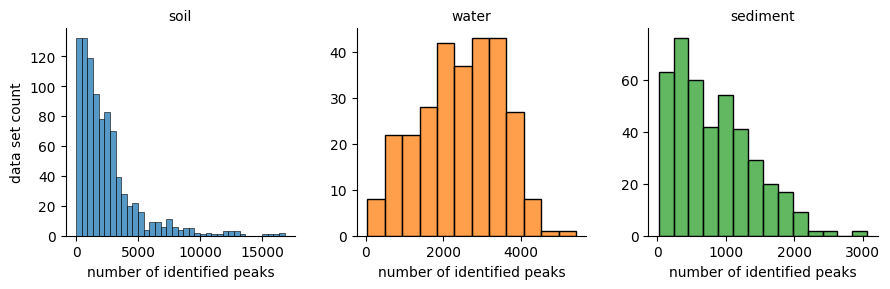

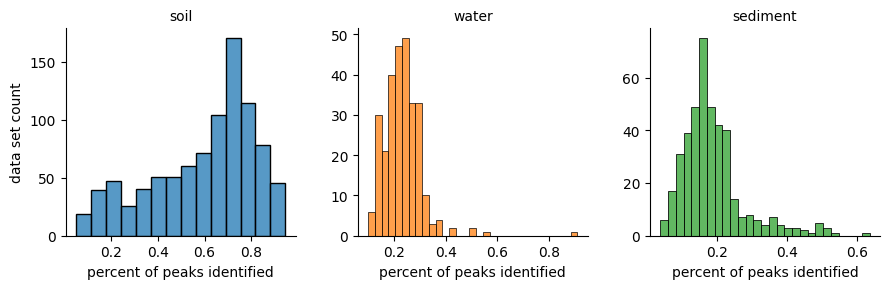

In [16]:
peak_count_plot=sns.FacetGrid(nom_summary_df,col="sample_type",hue="sample_type",sharex=False,sharey=False)
peak_count_plot.map(sns.histplot,'assigned_peak_count')
peak_count_plot.set_xlabels("number of identified peaks")
peak_count_plot.set_ylabels("data set count")
peak_count_plot.set_titles(col_template="{col_name}")

peak_perc_plot=sns.FacetGrid(nom_summary_df,col="sample_type",hue="sample_type",sharex=False,sharey=False)
peak_perc_plot.map(sns.histplot,'assigned_perc')
peak_perc_plot.set_xlabels("percent of peaks identified")
peak_perc_plot.set_ylabels("data set count")
peak_perc_plot.set_titles(col_template="{col_name}")

Apply filters to obtain high quality processed NOM data sets without removing all the files from any one sample type. Based on the figures above, requiring files to have at least 250 identified peaks that account for at least 30% of their total peak count will maintain a healthy number of data sets across sample types.

In [17]:
#filter data sets according to stats on peak assignment
nom_filt=nom_summary_df[nom_summary_df['assigned_peak_count']>=250]
nom_filt=nom_filt[nom_filt['assigned_perc']>=0.3]

#expand listed columns in molecular formula df
nom_filt_expanded=nom_filt.explode(['mol_form','H/C','O/C','Confidence Score'])

#resave expanded columns as numeric
nom_filt_expanded['O/C']=pd.to_numeric(nom_filt_expanded['O/C'])
nom_filt_expanded['H/C']=pd.to_numeric(nom_filt_expanded['H/C'])
nom_filt_expanded['Confidence Score']=pd.to_numeric(nom_filt_expanded['Confidence Score'])

#metadata group column
grouping_column='sample_type'

#count number of datasets in each type
count_type=nom_filt_expanded[['processed',grouping_column]].drop_duplicates().value_counts(grouping_column)

count_type

sample_type
soil        763
sediment     41
water        31
Name: count, dtype: int64

Randomly sample a minimum number of data sets to visualize from each sample type

In [18]:
#determine sampling size based on counts above
n=min(pd.DataFrame(count_type)['count'])

#list the different types
list_type=count_type.index.tolist()

#for each type, randomly sample n data sets and save them into list
nom_sampled=[]
for type in list_type:
    #each processed ID and sample type
    nom_type=nom_filt_expanded[['processed',grouping_column]].drop_duplicates()
    #filter to current sample type
    nom_type=nom_type[nom_type[grouping_column]==type]
    #randomly sample n processed IDs in current sample type
    nom_type=nom_type.sample(n=n, random_state=2)
    #save
    nom_sampled.append(nom_type)

#resave list as dataframe
nom_sampled=pd.concat(nom_sampled)

#remerge rest of the data for the sampled data sets
nom_sampled=nom_sampled.merge(nom_filt_expanded,on=['processed',grouping_column],how="left")

nom_sampled

processed sample_type  assigned_peak_count  assigned_perc  \
0       nmdc:dobj-11-fdnea285        soil                  362       0.591503   
1       nmdc:dobj-11-fdnea285        soil                  362       0.591503   
2       nmdc:dobj-11-fdnea285        soil                  362       0.591503   
3       nmdc:dobj-11-fdnea285        soil                  362       0.591503   
4       nmdc:dobj-11-fdnea285        soil                  362       0.591503   
...                       ...         ...                  ...            ...   
214686  nmdc:dobj-11-kema8883       water                 3862       0.308146   
214687  nmdc:dobj-11-kema8883       water                 3862       0.308146   
214688  nmdc:dobj-11-kema8883       water                 3862       0.308146   
214689  nmdc:dobj-11-kema8883       water                 3862       0.308146   
214690  nmdc:dobj-11-kema8883       water                 3862       0.308146   

                mol_form       H/C       O/C  Confidence Score  
0            C24 H42 O21  1.750000  0.875000          0.578383  
1             C31 H44 O7  1.419355  0.225806          0.597380  
2             C28 H40 O8  1.428571  0.285714          0.598472  
3            C18 H32 O16  1.777778  0.888889          0.992089  
4       C17 H32 O16 13C1  1.882353  0.941176          0.989387  
...                  ...       ...       ...               ...  
214686        C14 H13 N1  0.928571  0.000000          0.594623  
214687      C7 H13 O5 N1  1.857143  0.714286          0.593764  
214688    C7 H9 O3 S1 N1  1.285714  0.428571          0.505508  
214689          C8 H4 O5  0.500000  0.625000          0.552868  
214690       C7 H8 O3 S1  1.142857  0.428571          0.558673  

[214691 rows x 8 columns]

Filter to high confidence peaks (score greater than 0.3) and high frequency molecular formulas (present in more than 5 data sets). This will leave us with the most informative data.

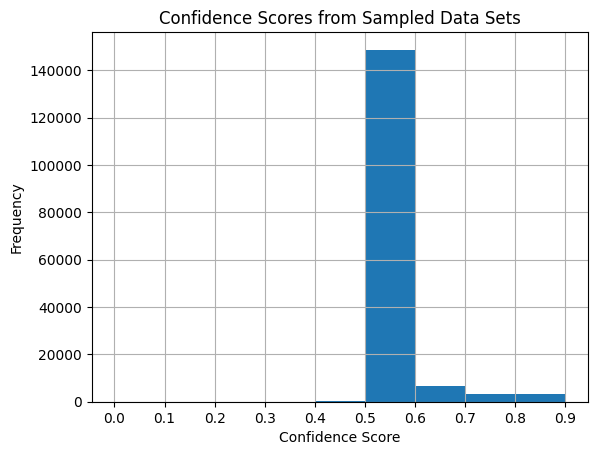

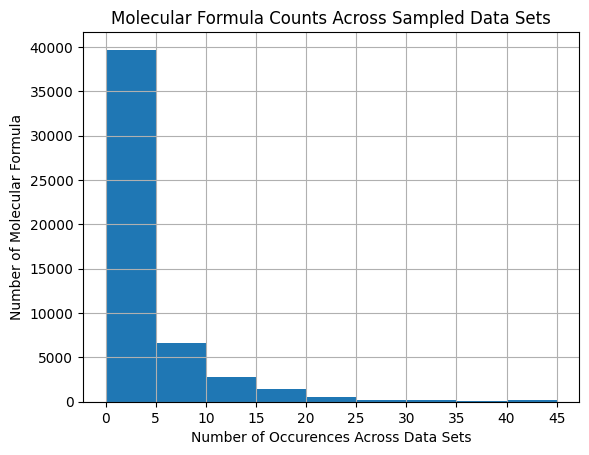

In [19]:
#histogram of confidence scores for randomly selected samples
nom_sampled.hist("Confidence Score",bins=np.arange(0,1,0.1))
plt.title('Confidence Scores from Sampled Data Sets')
plt.xlabel("Confidence Score")
plt.xticks(np.arange(0,1,0.1))
plt.ylabel("Frequency")
plt.show()

#peak filtering by confidence score
conf_filt=nom_sampled[nom_sampled['Confidence Score']>=0.3]

#count for each molecular formula
mol_counts=conf_filt.value_counts('mol_form').to_frame().reset_index()

#histogram of molecular formula counts
mol_counts.hist("count",bins=np.arange(0,50,5))
plt.locator_params(axis='x')
plt.title('Molecular Formula Counts Across Sampled Data Sets')
plt.xlabel("Number of Occurences Across Data Sets")
plt.xticks(np.arange(0,50,5))
plt.ylabel("Number of Molecular Formula")
plt.show()

#based on this histogram, filter to formulas in more than 5 data sets
mol_counts=mol_counts[mol_counts['count']>=5]
mol_filter=mol_counts.merge(conf_filt,on=['mol_form'],how="left")


### Assess patterns in the molecular formulas from different sample types

Create a clustermap of the processed NOM data sets (x axis), indicating the presence (black) or absence (white) of molecular formulas (y axis). The color bar will indicate sample type and help visualize the molecular similarity of data sets both within and between sample types.  

/home/bmeluch/NMDC/notebooks/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/bmeluch/NMDC/notebooks/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


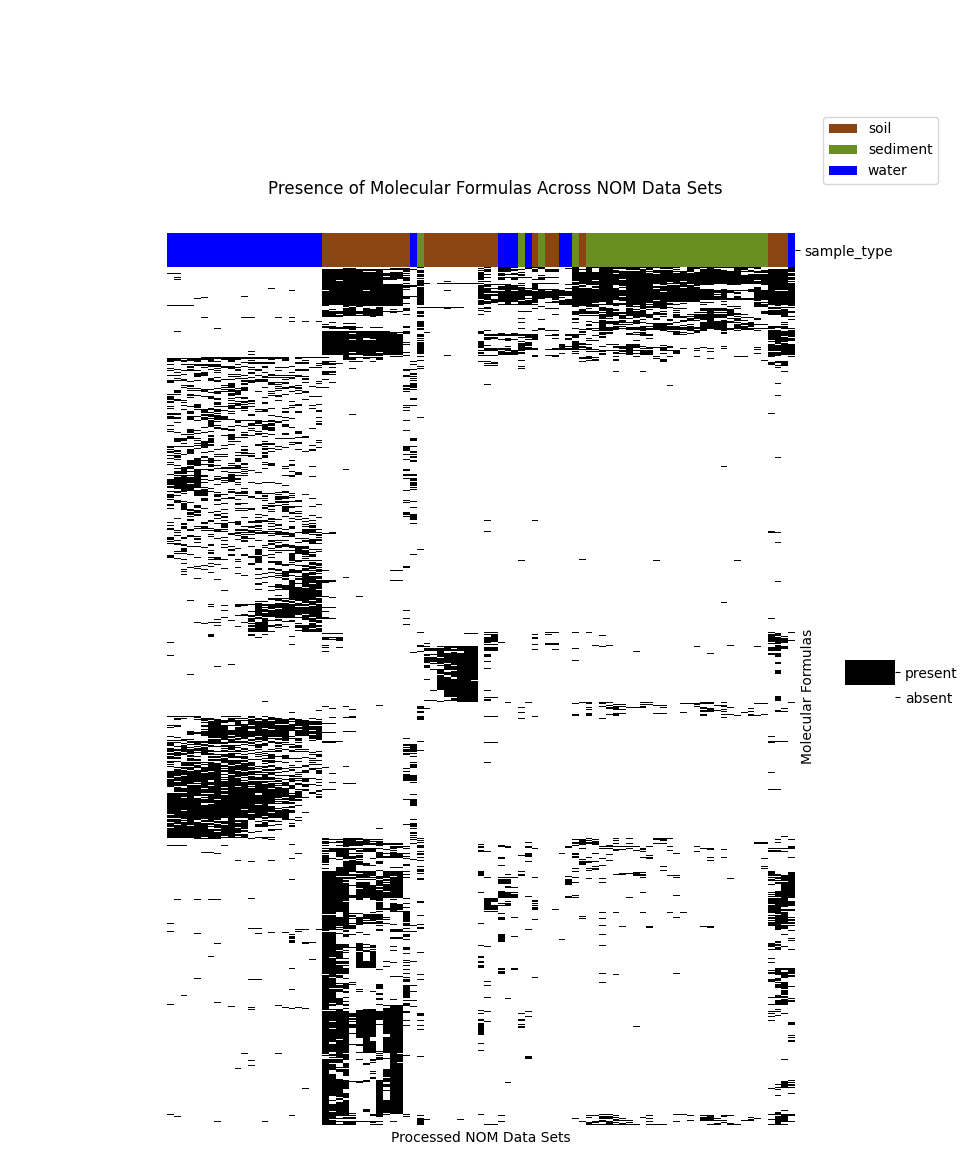

In [ ]:
#sample type colors

#set colors for each sample type
type_col=pd.DataFrame({grouping_column:mol_filter[grouping_column].unique(),'color':['#8B4513','olivedrab','blue']})#,'#B8860B']})

#setup color legend for sample type
type_col_dict = dict(zip(type_col[grouping_column].unique(), ['#8B4513','olivedrab','blue'])) #,'#B8860B'])) temporarily just 3 sample types until we fix material processing search
handles = [Patch(facecolor=type_col_dict[name]) for name in type_col_dict]

#map graph colors based on sample type to processed IDs
sample_type=mol_filter[[grouping_column,'processed']].drop_duplicates()
sample_type_col=sample_type.merge(type_col,how='left',on=grouping_column).set_index('processed').drop(grouping_column,axis=1).rename(columns={'color':grouping_column})

#presence/absence

#set colors for presence/absence as cmap
colors=['white','black']
custom_palette = sns.color_palette(colors)
custom_cmap = sns.color_palette(custom_palette, as_cmap=True)

#add column indicating presence in that processed nom id (1 is present)
mol_filter['presence']=1

#create presence/absence matrix. replace NA with 0 (0 is absent)
formula_matrix=mol_filter[['mol_form','processed','presence']].pivot_table('presence', index='mol_form', columns='processed').fillna(0).astype(int)

#heatmap (1 is present, zero is absent)
g=sns.clustermap(data=formula_matrix,col_colors=sample_type_col,tree_kws={"linewidths": 0.},xticklabels=False,yticklabels=False,cmap=custom_cmap)
g.figure.suptitle("Presence of Molecular Formulas Across NOM Data Sets")
g.ax_heatmap.set_xlabel("Processed NOM Data Sets")
g.ax_heatmap.set_ylabel("Molecular Formulas")

#adjust plot and legend locations
g.figure.subplots_adjust(top=1.15,right=0.8)
g.ax_cbar.set_position((0.85, 0.45, .05, .05)) #x axis,y axis, width, height

#adjust cbar legend to indicate presence/absence
g.ax_cbar.set_yticks([0.25,0.75])
g.ax_cbar.set_yticklabels(["absent","present"])

#add sample type legend
plt.legend(handles, type_col_dict, title=None,
           bbox_to_anchor=(0.95, 1.05), bbox_transform=plt.gcf().transFigure)

Create Van Krevelen diagrams to visually assess the atomic composition of each sample type. Van Krevelen diagrams plot the hydrogen to carbon ratio against the oxygen to carbon ratio, historically to assess petroleum samples.

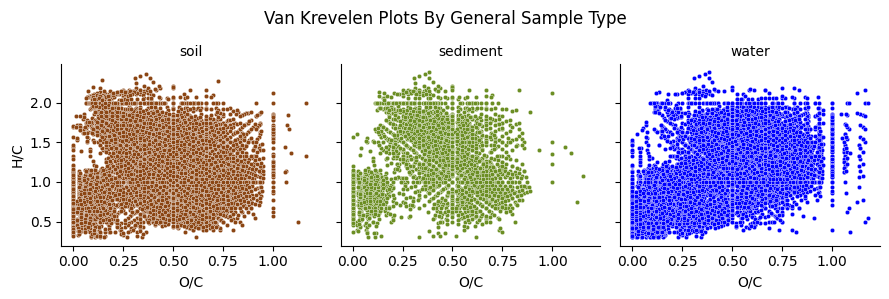

In [22]:
# the same molecular formula will have the same H/C and O/C value in every data set, so dots are only unique per sample type
vankrev_data=mol_filter[[grouping_column,'mol_form','H/C','O/C']].drop_duplicates()

#make van krevlen plot
g=sns.FacetGrid(vankrev_data,col=grouping_column,hue=grouping_column,palette=type_col_dict)
g.map(sns.scatterplot,'O/C','H/C',s=10)
g.set_titles(col_template="{col_name}")
g.figure.suptitle("Van Krevelen Plots By General Sample Type")
g.figure.subplots_adjust(top=0.8)

Create marginal density plot to assess how molecular formulas unique to each sample type compare to those shared by all four sample types.

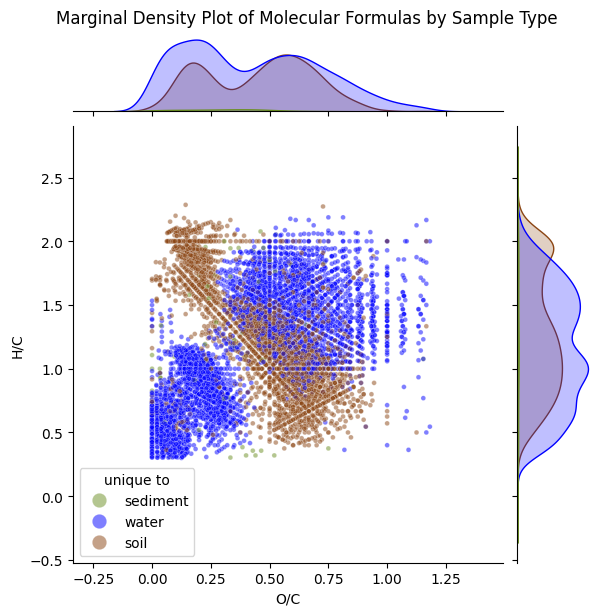

In [23]:
#count the number of sample types in which each molecular formula is found
density_counts=vankrev_data['mol_form'].value_counts()

#map counts back to H/C and O/C data
vankrev_data['common_to'] = vankrev_data['mol_form'].map(density_counts)

#filter molecular formual present in either all four sample types or in only one
vankrev_data=vankrev_data[vankrev_data['common_to'].isin([1,4])]

#reformat so sample type is 'all' when molecular formula was in all
vankrev_data.loc[vankrev_data['common_to']==4,'sample_type']='all types'

#add 'all' to sample type color dictionary
type_col_dict.update({'all types':'black'})

#make marginal density plot
sns.jointplot(data=vankrev_data, x="O/C", y="H/C", kind="scatter", hue=grouping_column,palette=type_col_dict,s=12,alpha=0.5)
plt.legend(markerscale=3,title="unique to")
plt.suptitle("Marginal Density Plot of Molecular Formulas by Sample Type",y=1.02)
plt.show()
